In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from scipy.special import jv

rcParams['font.size'] = 16

from ComptonSpec_classic import Trajectory, Spectrum

## Rectangle laser pulse: Comparison with analytics

In [2]:
u0, r0 = np.array([0.,0.,0.]), np.array([0.,0.,0.])
traj = Trajectory(u0, r0)

# Laser pulse parameters - define rectangular pulse
tau = 20 * 2 * np.pi  # Pulse duration
a0 = 1               # Pulse amplitude
mode = 'rectangle'       # Temporal envelope

def envelope(x, mode='super gauss'):
    if mode == 'rectangle':
        idx = (x >= -tau/2) & (x <= tau/2)
        g = np.zeros_like(x)
        g[idx] = 1
    elif mode == 'super gauss':
        g = np.exp(-(x/tau)**60)
    elif mode == 'gauss':
        g = np.exp(-x**2/tau**2)
    return g

def phase(x):
    return x

envelope = np.vectorize(envelope)
phase = np.vectorize(phase)

def calc_A(x):
    ph = phase(x)
    # return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.sin(ph)]) # circular
    return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.zeros_like(ph)]) # linear

eta_b = 1*tau
eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
A = calc_A(eta)
u, r = traj.calc_u_x(A, eta)

<ipython-input-3-8014bb2f6cde>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(eta, u[1]/np.max(u[1]), label='$u_y$')


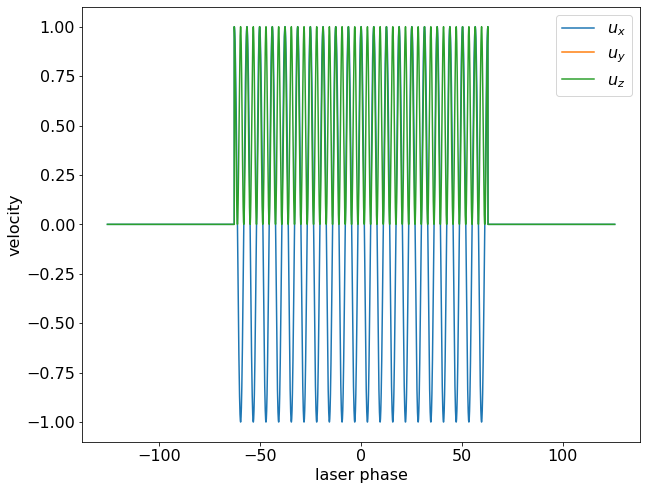

<ipython-input-3-8014bb2f6cde>:14: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(eta, r[1]/np.max(r[1]), label='$y$')


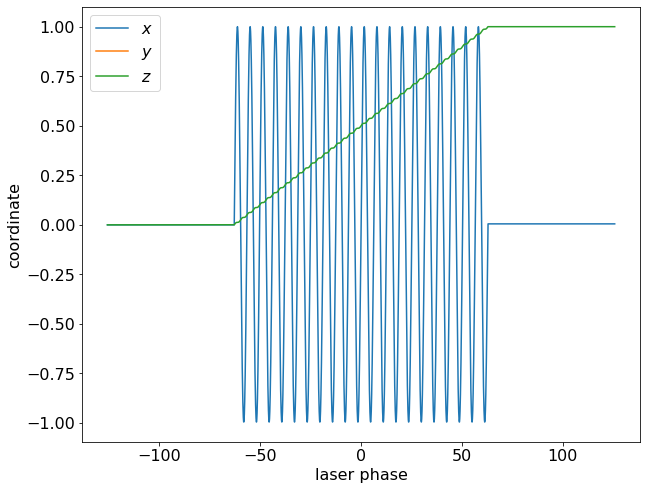

In [3]:
# Plot electron velocity and coordinate

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, u[0]/np.max(u[0]), label='$u_x$')
plt.plot(eta, u[1]/np.max(u[1]), label='$u_y$')
plt.plot(eta, u[2]/np.max(u[2]), label='$u_z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('velocity')
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, r[0]/np.max(r[0]), label='$x$')
plt.plot(eta, r[1]/np.max(r[1]), label='$y$')
plt.plot(eta, r[2]/np.max(r[2]), label='$z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('coordinate')
plt.show()

In [4]:
def calc_spectrum_I_w_analytics(w, a0=1, delta=0, n=1):
    '''
    Analytic expressions for the on-axis Compton spectrum for rectangular pulse
    w - frequency grid
    a0 - dimensionless amplitude
    delta - polarization of the pulse: delta=1 - circular, delta=0 - linear
    n - harmonic number
    '''
    alpha = 0.25 * w * a0**2 * (1 - delta**2)
    w_tilde = w * (1 + 0.5*a0**2 * (1 + delta**2))
    w_minus = w_tilde - n
    
    nu_plus = int(0.5*(n+1))
    nu_minus = int(0.5*(n-1))
    
    I_x = a0 * (jv(nu_minus, alpha) - jv(nu_plus, alpha)) * np.sin(w_minus*tau/2) / w_minus
    I_y = a0 * delta * (jv(nu_minus, alpha) + jv(nu_plus, alpha)) * np.sin(w_minus*tau/2) / w_minus
    I = w**2 * (np.abs(I_x)**2 + np.abs(I_y)**2) / (4*np.pi**2)
    
    return I

In [5]:
# Calculate spectrum numerically
spec = Spectrum(eta, u, r)

theta = np.pi
phi = 0
I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi)

In [6]:
I_analytics = calc_spectrum_I_w_analytics(w, a0=a0, delta=0, n=1)

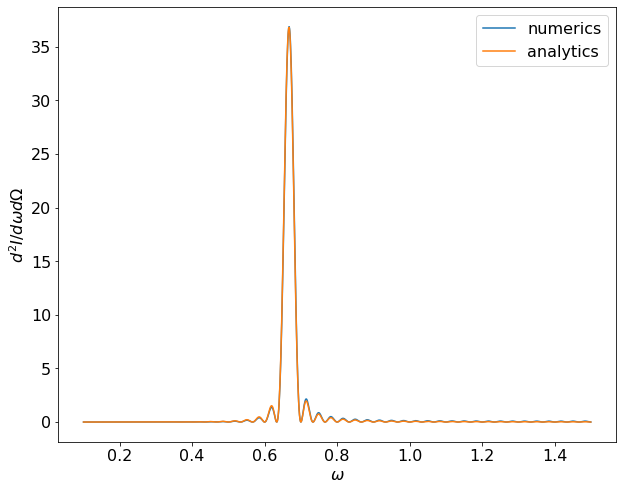

Mean discrepancy: 0.008491907058713298


In [7]:
# Plot spectrum I(w)
w0, w1 = [0.1, 1.5]
idx = (w >= w0) & (w <= w1)
w_plot, I_plot, I_analytics_plot = w[idx], I[idx], I_analytics[idx]

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(w_plot, I_plot, label='numerics')
plt.plot(w_plot, I_analytics_plot, label='analytics')
plt.xlabel('$\omega$')
plt.ylabel('$d^2 I / d\omega d\Omega$')
plt.legend(loc='best')
plt.show()
# The agreement between approximate analytics solution and numerics is ok
error = np.mean((I_plot - I_analytics_plot)**2)
print('Mean discrepancy: {}'.format(error))

## Thomson cross section
$\sigma_{Th} = \frac{8\pi}{3} r_e^2$, $r_e$ - electron classical radius.

$<S> = \frac{c}{4\pi} <|\mathbf{E}|^2>$

$\sigma = r_e^2 \cdot P \cdot 2 \int \frac{d^2 I}{d\omega d\Omega} d\Omega d\omega\: /\: a_0^2 n_{periods}$

$P = 1$ for circular polarization, $P = 2$ for linear.

In [8]:
u0, r0 = np.array([0.,0.,0.]), np.array([0.,0.,0.])
traj = Trajectory(u0, r0)

# Laser pulse parameters - define rectangular pulse
n_periods = 40
tau = n_periods * 2 * np.pi   # Pulse duration
a0 = 0.1               # Pulse amplitude
mode = 'rectangle'       # Temporal envelope
polarization = 'circular'

def envelope(x, mode='super gauss'):
    if mode == 'rectangle':
        idx = (x >= -tau/2) & (x <= tau/2)
        g = np.zeros_like(x)
        g[idx] = 1
    elif mode == 'super gauss':
        g = np.exp(-(x/tau)**60)
    elif mode == 'gauss':
        g = np.exp(-x**2/tau**2)
    return g

def phase(x):
    return x

envelope = np.vectorize(envelope)
phase = np.vectorize(phase)

def calc_A(x):
    ph = phase(x)
    if polarization == 'circular':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.sin(ph)]) # circular
    elif polarization == 'linear':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.zeros_like(ph)]) # linear

eta_b = 1*tau
eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
A = calc_A(eta)
u, r = traj.calc_u_x(A, eta)

In [9]:
# Calculate spectrum numerically
spec = Spectrum(eta, u, r)

theta_start, theta_end = 0., np.pi
n_theta = 20
theta_arr = np.linspace(theta_start, theta_end, n_theta)

if polarization == 'linear':
    phi_start, phi_end = 0, 2*np.pi
    n_phi = 20
    phi_arr = np.linspace(phi_start, phi_end, n_phi)
    I_phi_theta_w, _, _, w = spec.calc_spectrum_I_phi_theta_w(phi_arr, theta_arr, w_bound=[0,3.])
    d_phi = phi_arr[1] - phi_arr[0]
    I_theta_w = np.sum(I_phi_theta_w, axis=0) * d_phi
elif polarization == 'circular':
    I_theta_w, _, w = spec.calc_spectrum_I_theta_w(theta_arr, phi=0, interpolate_w=True, w_bound=[0,3.])

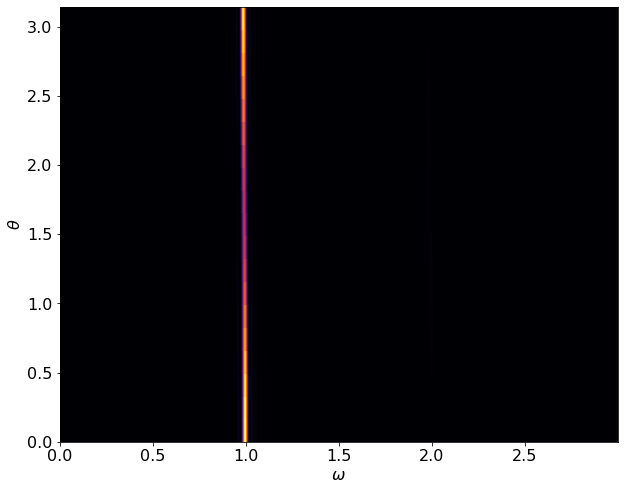

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
plt.pcolormesh(w, theta_arr, I_theta_w, cmap='inferno')
plt.xlabel('$\omega$')
plt.ylabel('$\\theta$')
plt.show()

In [11]:
I_w = Spectrum.collimate_I_theta_w(I_theta_w, theta_arr, w, theta_col=np.pi)
I = Spectrum.integrate_I_w(I_w, w, w_bound=[0.,3.])
if polarization == 'circular':
    I *= 2*np.pi
P = 2 if polarization == 'linear' else 1
cross_section = 2 * P * I / a0**2 / n_periods
cross_section_Th = 8 * np.pi / 3
err_abs = np.abs(cross_section - cross_section_Th)
err_rel = cross_section / cross_section_Th
print('Absolute difference: {}'.format(err_abs))
print('Relative difference: {}'.format(err_rel))

Absolute difference: 0.018028654173956937
Relative difference: 1.0021520120718097


## Comparison with quantum code (by Vasily)

Here we provide a couple of comparisons between our solution and quantum-based simulation code by Vasily. Quantum simulation results are stored in a separate folder.

Available data:\
    - $a_0 = 1, \tau=30\pi$ gauss envelope, circular polarization\
    - $a_0 = 1, \tau=30\pi$ gauss envelope, linear polarization

In [12]:
u0, r0 = np.array([0.,0.,0.]), np.array([0.,0.,0.])
traj = Trajectory(u0, r0)

# Available data from quantum code for a0=1, tau=30pi
# case = 0 -> 'gauss', 'circular'
# case = 1 -> 'gauss', 'linear'
case = 1

# Laser pulse parameters - define rectangular pulse
n_periods = 15
tau = n_periods * 2 * np.pi   # Pulse duration
a0 = 1               # Pulse amplitude
if case == 0:
    mode = 'gauss'       
    polarization = 'circular'
elif case == 1:
    mode = 'gauss'       
    polarization = 'linear'

def envelope(x, mode='super gauss'):
    if mode == 'rectangle':
        idx = (x >= -tau/2) & (x <= tau/2)
        g = np.zeros_like(x)
        g[idx] = 1
    elif mode == 'super gauss':
        g = np.exp(-(x/tau)**60)
    elif mode == 'gauss':
        g = np.exp(-x**2/tau**2)
    return g

def phase(x):
    return x

envelope = np.vectorize(envelope)
phase = np.vectorize(phase)

def calc_A(x):
    ph = phase(x)
    if polarization == 'circular':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.sin(ph)]) # circular
    elif polarization == 'linear':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.zeros_like(ph)]) # linear

eta_b = 3.2*tau
eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
A = calc_A(eta)
u, r = traj.calc_u_x(A, eta)

<ipython-input-13-8014bb2f6cde>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(eta, u[1]/np.max(u[1]), label='$u_y$')


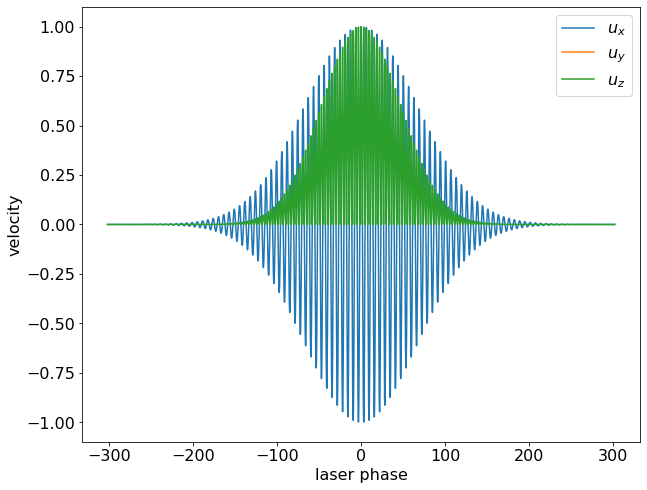

<ipython-input-13-8014bb2f6cde>:14: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(eta, r[1]/np.max(r[1]), label='$y$')


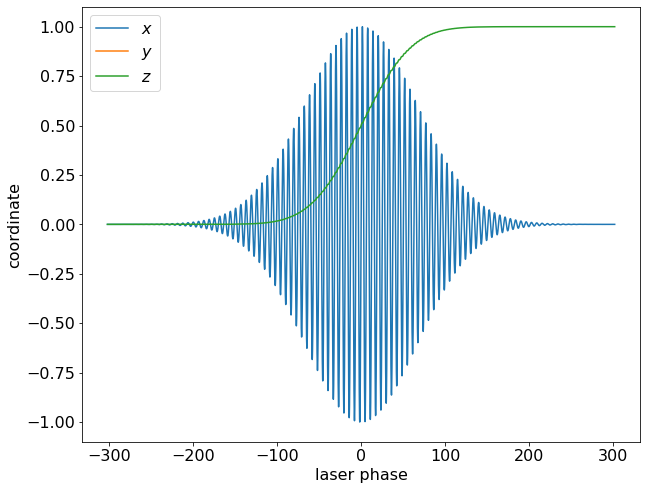

In [13]:
# Plot electron velocity and coordinate

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, u[0]/np.max(u[0]), label='$u_x$')
plt.plot(eta, u[1]/np.max(u[1]), label='$u_y$')
plt.plot(eta, u[2]/np.max(u[2]), label='$u_z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('velocity')
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, r[0]/np.max(r[0]), label='$x$')
plt.plot(eta, r[1]/np.max(r[1]), label='$y$')
plt.plot(eta, r[2]/np.max(r[2]), label='$z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('coordinate')
plt.show()

In [14]:
# Calculate spectrum numerically
spec = Spectrum(eta, u, r)

theta = np.pi
phi = 0
I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi)

In [15]:
# Load quantum simulations
if case == 0:
    file_name = 'quantum_benchmarks/gauss_a0_1_tau_15_circular/'
elif case == 1:
    file_name = 'quantum_benchmarks/gauss_a0_1_tau_15_linear/'
w_quantum = np.load(file_name + 'w.npy')
I_quantum = np.load(file_name + 'I.npy')
# Quantum code computes d^2 N_ph / dw dO, in data we already changed it to intensity

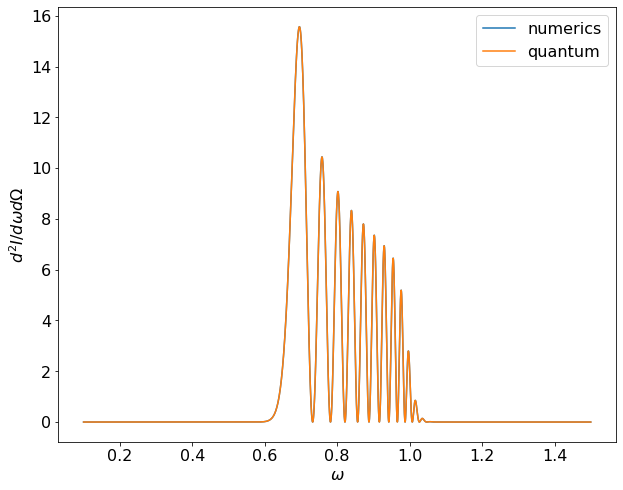

In [16]:
# Plot spectrum I(w)
w0, w1 = [0.1, 1.5]
idx = (w >= w0) & (w <= w1)
w_plot, I_plot = w[idx], I[idx]
idx_quantum = (w_quantum >= w0) & (w_quantum <= w1)
w_quantum_plot, I_quantum_plot = w_quantum[idx_quantum], I_quantum[idx_quantum]

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(w_plot, I_plot, label='numerics')
plt.plot(w_quantum_plot, I_quantum_plot, label='quantum')
plt.xlabel('$\omega$')
plt.ylabel('$d^2 I / d\omega d\Omega$')
plt.legend(loc='best')
plt.show()

## Comparison with VDSR
Here we provide a couple of comparisons between our solution and widely-used Compton classic simulation code - VDSR (link to the article is [here](https://journals.aps.org/prab/abstract/10.1103/PhysRevSTAB.16.030701)). VDSR results are stored in a separate folder.

Available vdsr data:\
    - $a_0 = 1, \tau=30\pi$ gauss envelope, circular polarization\
    - $a_0 = 1, \tau=30\pi$ gauss envelope, linear polarization

In [17]:
u0, r0 = np.array([0.,0.,0.]), np.array([0.,0.,0.])
traj = Trajectory(u0, r0)

# Available vdsr data for a0=1, tau=30pi
# case = 0 -> 'gauss', 'circular'
# case = 1 -> 'gauss', 'linear'
case = 0

# Laser pulse parameters - define rectangular pulse
n_periods = 15
tau = n_periods * 2 * np.pi   # Pulse duration
a0 = 1               # Pulse amplitude
if case == 0:
    mode = 'gauss'       
    polarization = 'circular'
elif case == 1:
    mode = 'gauss'       
    polarization = 'linear'

def envelope(x, mode='super gauss'):
    if mode == 'rectangle':
        idx = (x >= -tau/2) & (x <= tau/2)
        g = np.zeros_like(x)
        g[idx] = 1
    elif mode == 'super gauss':
        g = np.exp(-(x/tau)**60)
    elif mode == 'gauss':
        g = np.exp(-x**2/tau**2)
    return g

def phase(x):
    return x

envelope = np.vectorize(envelope)
phase = np.vectorize(phase)

def calc_A(x):
    ph = phase(x)
    if polarization == 'circular':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.sin(ph)]) # circular
    elif polarization == 'linear':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.zeros_like(ph)]) # linear

eta_b = 3.2*tau
eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
A = calc_A(eta)
u, r = traj.calc_u_x(A, eta)

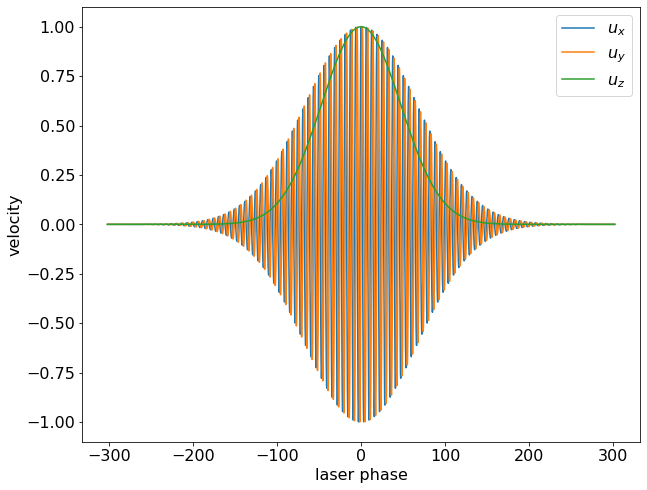

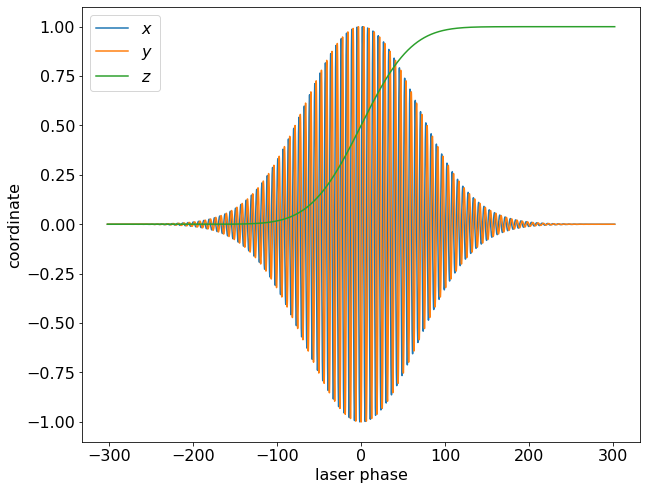

In [18]:
# Plot electron velocity and coordinate

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, u[0]/np.max(u[0]), label='$u_x$')
plt.plot(eta, u[1]/np.max(u[1]), label='$u_y$')
plt.plot(eta, u[2]/np.max(u[2]), label='$u_z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('velocity')
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(eta, r[0]/np.max(r[0]), label='$x$')
plt.plot(eta, r[1]/np.max(r[1]), label='$y$')
plt.plot(eta, r[2]/np.max(r[2]), label='$z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('coordinate')
plt.show()

In [19]:
# Calculate spectrum numerically
spec = Spectrum(eta, u, r)

theta = np.pi
phi = 0
I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi)

In [20]:
# Load VDSR simulations
if case == 0:
    file_name = 'vdsr_benchmarks/gauss_a0_1_tau_15_circular/'
elif case == 1:
    file_name = 'vdsr_benchmarks/gauss_a0_1_tau_15_linear/'
w_vdsr = np.load(file_name + 'w.npy')
I_vdsr = np.load(file_name + 'I.npy')
# vdsr simulations were performed for electron beam of 10^8 electrons
I_vdsr /= 10**8

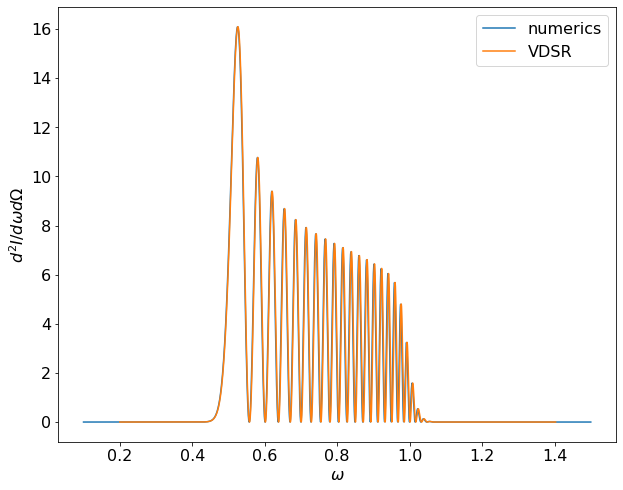

In [21]:
# Plot spectrum I(w)
w0, w1 = [0.1, 1.5]
idx = (w >= w0) & (w <= w1)
w_plot, I_plot = w[idx], I[idx]
idx_vdsr = (w_vdsr >= w0) & (w_vdsr <= w1)
w_vdsr_plot, I_vdsr_plot = w_vdsr[idx_vdsr], I_vdsr[idx_vdsr]

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(w_plot, I_plot, label='numerics')
plt.plot(w_vdsr_plot, I_vdsr_plot, label='VDSR')
plt.xlabel('$\omega$')
plt.ylabel('$d^2 I / d\omega d\Omega$')
plt.legend(loc='best')
plt.show()